# Motion Tracker

Let's see how this goes.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
from PIL import Image
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from model import MotionDataset, Network


#get min max
train_csv = pd.read_csv('train/input.csv')
test_csv = pd.read_csv('test/input.csv')
maxval = max(train_csv.drop([train_csv.columns[0], train_csv.columns[1]],axis=1).to_numpy().max(), test_csv.drop([test_csv.columns[0], test_csv.columns[1]],axis=1).to_numpy().max())
minval = min(train_csv.drop([train_csv.columns[0], train_csv.columns[1]],axis=1).to_numpy().min(), test_csv.drop([test_csv.columns[0], test_csv.columns[1]],axis=1).to_numpy().min())

helper_arr = (np.arange(train_csv.shape[1]) + 2) % 3 == 0
helper_arr[0], helper_arr[1] = False, False
maxval_z = max(train_csv.iloc[:, helper_arr].to_numpy().max(), test_csv.iloc[:, helper_arr].to_numpy().max())
minval_z = max(train_csv.iloc[:, helper_arr].to_numpy().min(), test_csv.iloc[:, helper_arr].to_numpy().min())


img_width = 256
#randomly rotate or transform the images to help training
train_transforms = transforms.Compose([
                                        transforms.Resize((img_width,img_width)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
#                                            ,transforms.Normalize([0.5, 0.5, 0.5], 
#                                                              [0.5, 0.5, 0.5])
                                       ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([
                                       transforms.Resize((img_width,img_width)),
                                       transforms.ToTensor()
#                                         ,transforms.Normalize([0.5, 0.5, 0.5], 
#                                                              [0.5, 0.5, 0.5])
                                           ,transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])
                                      ])

motions = MotionDataset('train/input.csv', 'train', train_transforms, (minval,maxval), (minval_z, maxval_z))
trainloader = DataLoader(motions, batch_size=16, shuffle=True)
img, height, transform = next(iter(trainloader))

motions_test = MotionDataset('test/input.csv', 'test', test_transforms, (minval,maxval), (minval_z, maxval_z))
testloader = torch.utils.data.DataLoader(motions_test, batch_size=16, shuffle=True)

[0.55100274 0.5480494  0.54568714 0.5867525  0.54911953 0.62672126
 0.56536204 0.6505125  0.5876932  0.6533822  0.59668326 0.6532719
 0.5662267  0.6476629  0.5239366  0.631863   0.46157527 0.61542827
 0.4182744  0.5580538  0.52616733 0.5237168  0.54542524 0.44636953
 0.5272576  0.3402325  0.5488195  0.3278315  0.6045991  0.65972936
 0.6472509  0.66500336 0.7351309  0.6382525  0.78602874 0.5965809
 0.58125746 0.5292458  0.68055063 0.435833   0.6639528  0.29424286
 0.70936173 0.25603643]
[1.1373615 1.1390953 1.2320602 1.4295514 1.6848904 1.79596   1.7117822
 1.7346067 1.3556209 1.1933768 1.2110686 1.7599238 1.8837706 2.162754
 1.5992204 1.4663497 1.2823715 1.4072334 1.0475647 1.2733715 0.9592583
 1.085971 ]
[0.5771745  0.5580184  0.58861506 0.5854728  0.5999634  0.61834484
 0.6097127  0.65719324 0.6165289  0.70267105 0.62114155 0.7327063
 0.62895125 0.6980298  0.64699686 0.6884118  0.70841897 0.64236206
 0.67217857 0.63346386 0.5838956  0.5413748  0.5255433  0.41356957
 0.4439106  0.2886

[0.58080745 0.5561445  0.58014375 0.59060127 0.5858168  0.63056433
 0.5896684  0.6769752  0.5909853  0.7302425  0.5803328  0.75892305
 0.5986829  0.7252029  0.61149246 0.7077927  0.5851494  0.6294518
 0.49829125 0.6763531  0.60141623 0.5352548  0.56781435 0.3848582
 0.62593204 0.26032633 0.5859625  0.22241977 0.58381116 0.7221796
 0.57474864 0.7059585  0.57555556 0.66106385 0.50726336 0.6660956
 0.56377125 0.5389663  0.5405706  0.40536398 0.5678553  0.32200038
 0.5309713  0.29728878]
[1.3962871 1.3916769 1.3799735 1.3581223 1.3240991 1.2964303 1.2287515
 1.0480497 0.9029856 0.8449142 1.2636685 1.1793379 1.2301555 1.1256547
 1.4285928 1.6430258 2.0191479 1.8354201 1.539255  1.6076634 1.9559064
 1.9248261]
[0.5909884  0.5421781  0.5957436  0.577271   0.595215   0.6167299
 0.58785415 0.65610284 0.57414293 0.69035435 0.5623529  0.7022159
 0.5584355  0.69286585 0.52448004 0.68626684 0.5122556  0.6381019
 0.4730179  0.5699594  0.57101166 0.52751684 0.49859118 0.3812022
 0.6075738  0.2408558 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.3618708 1.3482267 1.3444455 1.3358005 1.3207992 1.3232917 1.4025404
 1.5682969 1.6675192 1.8141836 1.5006272 1.6804858 1.3886241 1.3303939
 1.2377461 1.0824962 1.0425241 1.0611728 1.2294832 1.4807944 1.4644161
 1.5274146]
[0.5871755  0.54140973 0.5828021  0.57488024 0.5778237  0.6139293
 0.57164454 0.658796   0.56509304 0.71023643 0.5559248  0.73793644
 0.5822517  0.70454997 0.6201657  0.68787086 0.6423415  0.60552007
 0.6628609  0.51919657 0.6053953  0.52475524 0.5426755  0.38519907
 0.5848841  0.26187706 0.55434906 0.21797375 0.5504355  0.7031785
 0.528841   0.6887598  0.5080169  0.6170516  0.4871832  0.5414458
 0.57650924 0.5211628  0.5759371  0.37880215 0.6848071  0.29315412
 0.696134   0.23978664]
[1.4616032 1.4758652 1.4718899 1.4357309 1.3594414 1.28663   1.3038895
 1.2332569 1.2175043 1.202894  1.3052827 1.1956854 1.3048159 1.1342655
 1.4354426 1.6141154 1.5223544 1.3661276 1.6062201 1.4358392 1.325703
 1.2834853]
[0.5790031  0.6019751  0.5773897  0.63470405 0.57173425 0.673

torch.Size([16, 3, 256, 256])

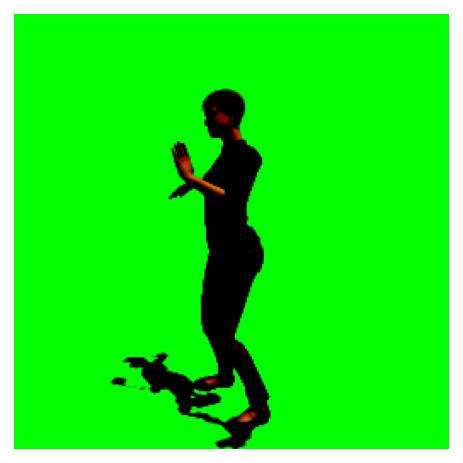

In [2]:
import helper
images, height, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)
# images = images.view(images.shape[0], -1)

images.shape

## Prepare neural network model


In [3]:
model = Network(img_width)
# Set biases to all zeros
#model.hidden.bias.data.fill_(0)
# sample from random normal with standard dev = 0.01
#model.hidden.weight.data.normal_(std=0.01)
print(model)

Network(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=262145, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=66, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Train our model

best loss 
Training loss: 0.0042177562236808885
 Test loss: 0.005721507128328085

In [ ]:
from torch import optim, nn
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.03333)
criterion = nn.MSELoss() 
# criterion = nn.L1Loss(reduction="none") 
print(torch.cuda.get_device_name(0))
train_losses, test_losses = [], []
epochs = 60
device = 'cuda'
model.to(device)
for e in range(epochs):
    running_loss = 0
    for images, heights, targets in trainloader:
        images, heights, targets = images.to(device), heights.to(device), targets.to(device)
#         print(images.shape, targets.shape)
        #1. forward pass
        ps = model.forward(images, heights)
#         print(ps.shape, targets.shape)
#         print(np.min(ps.cpu().detach().numpy()), np.min(targets.cpu().detach().numpy()))
#         print(np.max(ps.cpu().detach().numpy()), np.max(targets.cpu().detach().numpy()))
#         print(ps[0], targets[0])
        #2. calculate loss
        loss = criterion(ps, targets)
#         loss = loss.sum(1).sum()
#         print(loss)
        #0. Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        #3. run backward propagation
        loss.backward()

        # 4. Take an update step and few the new weights
        optimizer.step()
        running_loss += loss.item()
#         print(loss.item())
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, heights, targets in testloader:
                images, heights, targets = images.to(device), heights.to(device), targets.to(device)
                ps = model.forward(images, heights)
                test_loss += criterion(ps, targets)
#                 test_loss = test_loss.sum(1).sum().item()
        
        model.train()
        
        test_loss = test_loss/len(testloader)
        train_loss = running_loss/len(trainloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Training loss: {train_loss}\n Test loss: {test_loss}\n")
        
PATH = 'model.m'
torch.save(model.state_dict(), PATH)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
test_losses = [test_loss.to('cpu') for test_loss in test_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Use our model

In [ ]:
%matplotlib inline
# test_transform = transforms.Compose([transforms.Resize((img_width,img_width)),
#                                 transforms.ToTensor()])

# test_dataset = datasets.ImageFolder('train/', transform=test_transform)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=True)
images, heights, labels = next(iter(testloader))
helper.imshow(images[0], normalize=False)
helper.imshow(images[1], normalize=False)

model.to('cpu')

# img = images[0].view(1, 195075)
# img = torch.zeros(1,120000) + 222
# Turn off gradients to speed up this part
print(labels.shape)
positions = []
positions_expected = []
with torch.no_grad():
    logps = model.forward(images, height)
    logps_denormalized = logps 
    labels_denormalized = labels 
    print(np.min(logps_denormalized[0].numpy()), np.min(labels_denormalized[0].numpy()))
    print(np.max(logps_denormalized[0].numpy()), np.max(labels_denormalized[0].numpy()))
#     print(logps_denormalized[0] * 10 - 5, labels_denormalized[0])
    for body_index in range(22):
        xyz = []
        xyz_e = []
        for pos_index in range(3):
            xyz.append(logps_denormalized[0][body_index*3+pos_index])
            xyz_e.append(labels_denormalized[0][body_index*3+pos_index])
        positions.append(xyz)
        positions_expected.append(xyz_e)
#     print(list(model.parameters()))



In [ ]:
positions = np.array(positions)
positions_expected = np.array(positions_expected)
fig = plt.figure()
ax = plt.axes(projection='3d')

zdata = positions.T[1]
xdata = positions.T[0]
ydata = positions.T[2]
ax.scatter3D(xdata, ydata, zdata);

zdata_e = positions_expected.T[1]
xdata_e = positions_expected.T[0]
ydata_e = positions_expected.T[2]
ax.scatter3D(xdata_e, ydata_e, zdata_e, marker='^');

In [ ]:
distances = []
for i, pos in enumerate(positions):
    pos_exp = positions_expected[i]
    dist = np.linalg.norm(pos_exp-pos)
    distances.append(dist)

plt.plot(distances, label='Distances')
plt.legend(frameon=False)

## 